In [1]:
import warnings
import numpy as np

# from keras_tqdm import TQDMNotebookCallback

from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scipy.misc import imsave
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

In [3]:
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

In [4]:
m = 250 # batch size
n_z = 2 # latent space size
encoder_dim1 = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.001)


n_x = X_train.shape[1]
n_y = y_train.shape[1]


n_epoch = 50

In [5]:
X = Input(shape=(n_x, ))
label = Input(shape=(n_y, ))
inputs = concat([X, label])

In [6]:
encoder_h = Dense(encoder_dim1, activation=activ, activity_regularizer='l2')(inputs)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)


In [7]:
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps # mean + log variance

z = Lambda(sample_z, output_shape= (n_z, ))([mu, l_sigma])

In [8]:
zc = concat([z, label])

In [9]:
# Decoder

decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

In [20]:
# Loss of a VAE is the reconstruction loss + KL divergence mu, log-sigma and standard normal (>)

def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
	return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [21]:
# define model

cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z + n_y, ))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

In [22]:
cvae.compile(optimizer=optim, loss=vae_loss, metrics=[KL_loss, recon_loss] )

In [23]:
# compile and fit
cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m, epochs=n_epoch,
                     validation_data = ([X_test, y_test], X_test),
                     callbacks = [EarlyStopping(patience = 5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 60us/step - loss: 259.5083 - KL_loss: 0.5107 - recon_loss: 257.8964 - val_loss: 169.6092 - val_KL_loss: 1.1343 - val_recon_loss: 167.5802
Epoch 2/50
60000/60000 [==============================] - 3s 43us/step - loss: 167.4321 - KL_loss: 1.8684 - recon_loss: 164.5148 - val_loss: 164.6241 - val_KL_loss: 1.8619 - val_recon_loss: 161.8852
Epoch 3/50
60000/60000 [==============================] - 3s 44us/step - loss: 163.7084 - KL_loss: 2.2212 - recon_loss: 160.5767 - val_loss: 161.1691 - val_KL_loss: 2.2979 - val_recon_loss: 157.9829
Epoch 4/50
60000/60000 [==============================] - 2s 41us/step - loss: 160.3216 - KL_loss: 2.4304 - recon_loss: 156.9796 - val_loss: 158.5672 - val_KL_loss: 2.5428 - val_recon_loss: 155.0825
Epoch 5/50
60000/60000 [==============================] - 3s 45us/step - loss: 157.8761 - KL_loss: 2.5226 - recon_loss: 154.4116 - val_loss: 156.3368 - va

Epoch 42/50
60000/60000 [==============================] - 2s 37us/step - loss: 135.9118 - KL_loss: 4.4665 - recon_loss: 130.7447 - val_loss: 136.3664 - val_KL_loss: 4.4207 - val_recon_loss: 131.2999
Epoch 43/50
60000/60000 [==============================] - 2s 40us/step - loss: 135.8496 - KL_loss: 4.4734 - recon_loss: 130.6806 - val_loss: 136.4498 - val_KL_loss: 4.5025 - val_recon_loss: 131.2581
Epoch 44/50
60000/60000 [==============================] - 2s 38us/step - loss: 135.8208 - KL_loss: 4.4811 - recon_loss: 130.6502 - val_loss: 136.2122 - val_KL_loss: 4.4994 - val_recon_loss: 131.0311
Epoch 45/50
60000/60000 [==============================] - 2s 40us/step - loss: 135.7559 - KL_loss: 4.4830 - recon_loss: 130.5882 - val_loss: 136.2728 - val_KL_loss: 4.4326 - val_recon_loss: 131.2072
Epoch 46/50
60000/60000 [==============================] - 2s 39us/step - loss: 135.7385 - KL_loss: 4.4931 - recon_loss: 130.5664 - val_loss: 136.2743 - val_KL_loss: 4.4678 - val_recon_loss: 131.1459


In [24]:
encoded_X0 = encoder.predict([X_train[0].reshape((1, 784)), y_train[0].reshape((1, 10))])
print(encoded_X0)

[[ 0.31635481  0.24023134]]


In [25]:
def construct_numvec(digit, z = None):
    out = np.zeros((1, n_z + n_y))
    out[:, digit + n_z] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)
    
sample_3 = construct_numvec(3)
print(sample_3)

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]


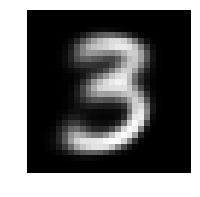

In [26]:
plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict(sample_3).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.show()

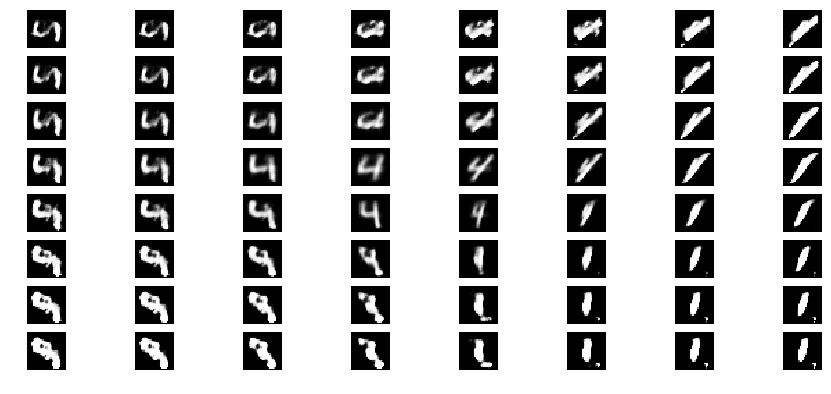

In [44]:
dig = 4
sides = 8
max_z = 8

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()

In [41]:
from IPython.core.pylabtools import figsize

In [42]:
figsize(12,5)